In [1]:
""" Load some libs """
""" python 2 lib using networkx """
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
import pandas as pd
import statsmodels.api as sm
import glob
import os
import numpy as np
from PIL import Image
from helpers import *
import pickle
import time
#random.seed(100)
#tic = time.time()

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
""" Let's see what WEPPS we have """
folders = sorted(glob.glob('WEPP_FILES/*'))
print folders
folder = folders[14]
print folder
DATE = 2017.75


['WEPP_FILES/2004-Q4-DEC', 'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2014-q4-dec', 'WEPP_FILES/2015-Q1-MAR', 'WEPP_FILES/2015-Q2-JUN', 'WEPP_FILES/2015-Q4-DEC', 'WEPP_FILES/2015-q3-sep', 'WEPP_FILES/2016-Q1-APR', 'WEPP_FILES/2016-Q2-JUL', 'WEPP_FILES/2016-Q3-SEP', 'WEPP_FILES/2016-Q4-DEC', 'WEPP_FILES/2017-Q1-MAR', 'WEPP_FILES/2017-Q2-JUL', 'WEPP_FILES/2017-Q3-SEP', 'WEPP_FILES/2017-Q4-DEC']
WEPP_FILES/2017-Q4-DEC


In [3]:
""" let's load in our WEPP db"""
wepp_df = get_wepp(folder)

csv ALLUNITS


In [4]:
""" fix all the wepp stuff, add all the columns """
def calculate_CCCE(wepp_df):
    # merge with ISO, country budgets and load factors 
    print '~~~~~~ GENERATING DF ~~~~~~~'
    print 'loading df...'
    df_iso = pd.read_csv('country_ISO_update.csv')
    fuel_class = 'fuel_classification_database.dta'
    df_fuel_class = pd.io.stata.read_stata(fuel_class)
    heat_rates_xls = 'Heat rates_v3.xls'
    df_heatrates = pd.read_excel(heat_rates_xls, sheet_name='CSV_output')
    df_load_factor = pd.io.stata.read_stata('load_factor_database.dta')

    print 'loaded dfs: '
    print 'merging dfs and filling missing years...'
    #df_fuel_load = pd.merge(df_fuel_class, df_load_factor, on='fuel_class')
    #print df_iso
    #print df_fuel_class
    #print df_heatrates
    #print df_load_factor
    #print list(wepp_df)
    #print wepp_df['FUEL']

    df_fuel_class.rename(columns = {'fuel': 'FUEL'}, inplace = True)
    
    #fix fuel classes
    wepp_df = wepp_df.merge(df_fuel_class, on='FUEL', how='left')
    df_wepp_em_fact = pd.read_csv('wepp_em_fact.csv')

    #merge emissions factors
    wepp_df = wepp_df.merge(df_wepp_em_fact, left_on='FUEL', right_on='fuel', how='left')

    #prepare lookup indexer
    wepp_df['FORMAT_HR'] = wepp_df.apply(lambda row: format_hr(row), axis=1)

    #standardise statuses
    wepp_df.loc[wepp_df.STATUS=='DEF', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DEL', 'STATUS'] = 'CON'
    wepp_df.loc[wepp_df.STATUS=='UNK', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DAC', 'STATUS'] = 'STN'

    #print  list(df_iso)

    #add ISO
    wepp_df = wepp_df.merge(df_iso[['Caps','ISO','Region']], left_on='COUNTRY', right_on='Caps', how='left')

    #fill in missing years
    all_training = wepp_df[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']]
    all_training['fuel_class'] = all_training['fuel_class'].astype('category')
    all_training['STATUS'] = all_training['STATUS'].astype('category')
    all_training['Region'] = all_training['Region'].astype('category')
    all_training['FORMAT_HR'] = all_training['FORMAT_HR'].astype('category')
    all_training = pd.get_dummies(all_training[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']], columns = ['fuel_class','STATUS','Region','FORMAT_HR'])

    year_train_X = all_training[all_training.YEAR.notnull()].drop('YEAR', axis=1)
    year_train_Y = all_training.loc[all_training.YEAR.notnull(),'YEAR']
    year_train_X = sm.add_constant(year_train_X)

    test_data = all_training.loc[all_training.YEAR.isnull()].drop('YEAR', axis=1)
    test_data = sm.add_constant(test_data)

    est = sm.OLS(year_train_Y, year_train_X)
    est = est.fit()

    wepp_df['YEAR_EST_FLAG'] = 0
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR_EST_FLAG'] = 1
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR'] = est.predict(test_data)


    #get heatrates
    wepp_df = wepp_df.merge(df_heatrates, left_on='FORMAT_HR', right_on='unique_id', how='left')
    wepp_df['HEATRATE'] = wepp_df.apply(lambda row: get_hr(row), axis=1)
    drop_cols = [col for col in list(wepp_df) if isinstance(col,int)]
    wepp_df.drop(drop_cols, axis=1, inplace=True)

    #get CO2 int, CCCE
    wepp_df = wepp_df.merge(df_load_factor, on='fuel_class', how='left')
    wepp_df['YEARS_LEFT'] = np.where(wepp_df['STATUS']=='OPR', wepp_df['YEAR']+40-2017, 0)
    wepp_df.YEARS_LEFT.clip(lower=0.0, inplace=True) #set min years left to 0
    print 'dfs merged and interped: '


    print 'calculating carbon and MWs...'

    wepp_df['CO2_INT'] = wepp_df['em_fact'] /2.205 * wepp_df['HEATRATE'] / 1000
    wepp_df['CCCE'] = 8760 * wepp_df['MW'] * wepp_df['YEARS_LEFT'] * wepp_df['load_factor'] * wepp_df['CO2_INT'] /1000 #tonnes 
    #wepp_df.sort_values('CCCE', inplace=True)

    #print wepp_df
    #print list(wepp_df)
    #print wepp_df.CCCE

    #get countries
    all_countries = wepp_df.ISO.unique()
    #print all_countries
    #exit()

    #sort WEPP
    wepp_df.sort_values('CCCE', inplace=True, ascending=False)

    wepp_df['green']=wepp_df.fuel_class.isin(['SUN','BIOGAS','WASTE','BIOOIL','WIND','BIOMASS','GEOTHERMAL'])
    wepp_df['green_MW'] = wepp_df.MW*wepp_df.green
    wepp_df['blue']=wepp_df.fuel_class.isin(['WATER','NUCLEAR'])
    wepp_df['blue_MW'] = wepp_df.MW*wepp_df.blue






    #plot companies by CCCE
    company_df = pd.DataFrame(wepp_df.CCCE.groupby(wepp_df['COMPANY']).sum())
    company_df.sort_values('CCCE', inplace=True, ascending=False)
    #print company_df


    for country in all_countries:
    	#for CCCE
    	#company_df[country] = wepp_df.loc[wepp_df.ISO==country,'CCCE'].groupby(wepp_df['COMPANY']).sum()

    	#for MW
    	company_df[country] = wepp_df.loc[wepp_df.ISO==country,'MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_green'] = wepp_df.loc[wepp_df.ISO==country,'green_MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_blue'] = wepp_df.loc[wepp_df.ISO==country,'blue_MW'].groupby(wepp_df['COMPANY']).sum()


    #checksum calculation
    #print list(company_df)
    #company_df.to_csv('test_nan.csv')
    company_df.drop(labels=[np.nan,'nan_green'], axis=1, inplace=True)

    iso_col = [h for h in list(company_df) if len(h)<3]
    company_df['checksum'] = company_df[iso_col].sum(axis=1)

    company_df.sort_values('checksum', inplace=True, ascending=False)
    #print company_df
    #see how many edges we've got
    #company_df['edges'] = company_df.count(axis=1)
    #print company_df.edges.mean()  #mean about 1.4 - nice.

    thresh = 1e8 #180000
    mw_thresh = 2000
    #print company_df
    company_subset_df = company_df[company_df.checksum>=mw_thresh]
    #print company_subset_df
    #iso_col = [h for h in list(company_subset_df) if len(h)<3]
    #print 'n_countries',len(iso_col)
    all_ccce = company_df.CCCE.sum()
    print 'all CCCE', all_ccce
    print 'por_CCCE',company_subset_df.CCCE.sum()/float(all_ccce)
    #exit()
    print 'calculated carbon and MWs: '

    return company_subset_df

In [5]:
""" let's get all those CCCEs"""
df = calculate_CCCE(wepp_df)

~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

dfs merged and interped: 
calculating carbon and MWs...
all CCCE 293963430936.0
por_CCCE 0.785521167225
calculated carbon and MWs: 


In [6]:
""" drop columns to just leave country columns """
df.dropna(axis = 1, how='all', inplace=True)

df_centroids = pd.read_csv('country_centroids.csv').set_index('country')
#print df_centroids.get_value('TH','latitude')


indices = list(df.index)
df.drop(['CCCE','checksum'], inplace=True, axis='columns')

In [7]:
""" get some subsets for green, blue MWs """
green_cols = [h for h in list(df) if 'green' in h]
blue_cols = [h for h in list(df) if 'blue' in h]
ISO_cols = [h for h in list(df) if len(h)<3]

df_green = df[green_cols].fillna(0.0) #df with companies as index, ISOs as columns
df_blue = df[blue_cols].fillna(0.0)
df = df[ISO_cols].fillna(0.0)
    
green_dict = {}
blue_dict = {}
    
for h in list(df_green):
    green_dict[h]=h[0:2]
for h in list(df_blue):
    blue_dict[h]=h[0:2]
    
df_green.rename(green_dict,axis='columns', inplace=True)
df_blue.rename(blue_dict,axis='columns', inplace=True)
    
    
print (list(df))
print (list(df_blue))
print (list(df_green))
  
df = df.T
df_blue = df_blue.T
df_green = df_green.T

['UA', 'RU', 'CZ', 'HR', 'BG', 'PL', 'CU', 'AU', 'AR', 'BR', 'TH', 'SY', 'IN', 'GB', 'MX', 'ES', 'KR', 'PK', 'BE', 'EG', 'PE', 'VN', 'NL', 'IT', 'DE', 'DK', 'NO', 'SG', 'FI', 'CH', 'SE', 'NG', 'JP', 'ET', 'PH', 'TM', 'IR', 'CL', 'AE', 'ZA', 'TR', 'MA', 'KE', 'KG', 'ZW', 'AT', 'SA', 'FR', 'GH', 'PT', 'LB', 'SD', 'IL', 'LY', 'OM', 'QA', 'LK', 'ID', 'GR', 'VE', 'NP', 'CO', 'PA', 'IE', 'HU', 'BD', 'LV', 'NZ', 'YE', 'JO', 'TJ', 'DZ', 'RO', 'CN', 'MY', 'CR', 'AO', 'DO', 'MM', 'PG', 'CY', 'RE', 'GT', 'EE', 'SI', 'IQ', 'UZ', 'EH', 'LT', 'CD', 'BH', 'KZ', 'IS', 'KW', 'SS', 'AZ', 'HT', 'MD', 'RS', 'UY', 'BT', 'KP', 'TZ', 'ME', 'KH', 'MZ', 'AL', 'TW', 'GP', 'BY', 'TN', 'SK', 'BA', 'MK', 'ZM', 'MQ', 'LA', 'US', 'CA']
['UA', 'RU', 'CZ', 'HR', 'BG', 'PL', 'CU', 'AU', 'AR', 'BR', 'TH', 'SY', 'IN', 'GB', 'MX', 'ES', 'KR', 'PK', 'BE', 'EG', 'PE', 'VN', 'NL', 'IT', 'DE', 'DK', 'NO', 'SG', 'FI', 'CH', 'SE', 'NG', 'JP', 'ET', 'PH', 'TM', 'IR', 'CL', 'AE', 'ZA', 'TR', 'MA', 'KE', 'KG', 'ZW', 'AT', 'SA', 'F

In [8]:
""" generate some country nodes"""
nodes = []
    
print 'Generating country nodes ...'
for j in df.index.values:
    #print ind
    #print df.at[ind,'CCCE']
    #g = 150
    #print j,' helloo'
    #print df_green.loc[df_green.index==j].sum(axis=1)
    g = int(df_green.loc[df_green.index==j].sum(axis=1)/df.loc[df.index==j].sum(axis=1)*255.0)
    b = int(df_blue.loc[df_blue.index==j].sum(axis=1)/df.loc[df.index==j].sum(axis=1)*255.0)
    #print g,b
    #print 'g',g, 'MW', df.at[indices[j],'checksum'],'size', math.exp(math.log((df.at[indices[j],'checksum']),2.0)/3)
    #raw_input('-->')
    #print j, indices[j]
    nodes.append(
            (j,{
                'type': 'country',
                'pos':np.array([df_centroids.get_value(j,'longitude'),df_centroids.get_value(j,'latitude')]),
                'n_color':"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
                'n_alpha':1.0,
                'n_size':(math.exp(math.log(df.loc[df.index==j].sum(axis=1),2.0)/3))}
            ))
print (nodes)

Generating country nodes ...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


[('UA', {'n_alpha': 1.0, 'n_size': 212.0861224500403, 'type': 'country', 'pos': array([ 31.16558 ,  48.379433]), 'n_color': '#00007b'}), ('RU', {'n_alpha': 1.0, 'n_size': 452.66511585368926, 'type': 'country', 'pos': array([ 105.318756,   61.52401 ]), 'n_color': '#000472'}), ('CZ', {'n_alpha': 1.0, 'n_size': 130.4311906355873, 'type': 'country', 'pos': array([ 15.472962,  49.817492]), 'n_color': '#00057e'}), ('HR', {'n_alpha': 1.0, 'n_size': 74.24749601388079, 'type': 'country', 'pos': array([ 15.2,  45.1]), 'n_color': '#000a6f'}), ('BG', {'n_alpha': 1.0, 'n_size': 97.85893697839639, 'type': 'country', 'pos': array([ 25.48583 ,  42.733883]), 'n_color': '#0005d7'}), ('PL', {'n_alpha': 1.0, 'n_size': 189.41567311338991, 'type': 'country', 'pos': array([ 19.145136,  51.919438]), 'n_color': '#001114'}), ('CU', {'n_alpha': 1.0, 'n_size': 76.10079122755407, 'type': 'country', 'pos': array([-77.781167,  21.521757]), 'n_color': '#000a1b'}), ('AU', {'n_alpha': 1.0, 'n_size': 218.43230913046327,

In [9]:
""" generate some country-country edges """
edges=[]

#Adjacency matrices in MW
ADJ_green = df_green.dot(df_green.T>0.0) #MW
ADJ_blue = df_blue.dot(df_blue.T>0.0) #MW
ADJ_ISO =df.dot(df.T>0.0) #MW

indices = list(ADJ_ISO.index)

#adjacency matrices in edge algo
ADJ_G_algo =  (df_green/df_green.sum()).dot(df_green.T/(df_green.T.sum()))
ADJ_B_algo = (df_blue/df_blue.sum()).dot(df_blue.T/(df_blue.T.sum()))
ADJ_I_algo = (df/df.sum()).dot(df.T/(df.T.sum()))


#for k1,k2s in ADJ_ISO.to_dict(orient='index').items():
#    for k2,v in k2s.items():
#        if v>0.0:
#            print (k1,k2,v)
#print ADJ_blue
#print ADJ_green

#df_ISO_pairs =  [ (k1,k2,v) for k2,v in k2s.items() for k1,k2s in ADJ_ISO.to_dict(orient='index').items()]

df_ISO_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_ISO.to_dict(orient='rows')]
df_ISO_pairs = dict(zip(indices,df_ISO_pairs))


df_green_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_green.to_dict(orient='rows')]
df_green_pairs = dict(zip(indices,df_green_pairs))

df_blue_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_blue.to_dict(orient='rows')]
df_blue_pairs = dict(zip(indices,df_blue_pairs))

    #print df_ISO_pairs

for k,v in df_ISO_pairs.items():
    v.pop(k,None)

    for k2,v2 in v.items():

        try:
            g = int(df_green_pairs[k][k2] / float(v2) * 255)
        except:
            g = 0

        try:
            b = int(df_blue_pairs[k][k2] / float(v2) * 255)
        except:
            b = 0

        edges.append(
            (k,k2,{
                'weight':np.log10(v2),
                'type':'country',
                'e_color': "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
            })) 
        
print edges


[('BD', 'CN', {'e_color': '#000000', 'type': 'country', 'weight': 2.0413926851582249}), ('BD', 'US', {'e_color': '#000000', 'type': 'country', 'weight': 2.0413926851582249}), ('BD', 'HT', {'e_color': '#000000', 'type': 'country', 'weight': 2.0413926851582249}), ('BD', 'IN', {'e_color': '#000000', 'type': 'country', 'weight': 2.0413926851582249}), ('BD', 'PK', {'e_color': '#000000', 'type': 'country', 'weight': 2.0413926851582249}), ('BE', 'FR', {'e_color': '#000400', 'type': 'country', 'weight': 2.6937269489236471}), ('BE', 'NL', {'e_color': '#001400', 'type': 'country', 'weight': 3.3598354823398879}), ('BE', 'PT', {'e_color': '#00ff00', 'type': 'country', 'weight': 1.2787536009528289}), ('BE', 'TW', {'e_color': '#00ff00', 'type': 'country', 'weight': 0.95424250943932487}), ('BE', 'DE', {'e_color': '#000200', 'type': 'country', 'weight': 2.9680157139936418}), ('BE', 'IT', {'e_color': '#00ff00', 'type': 'country', 'weight': 0.95424250943932487}), ('BE', 'HU', {'e_color': '#000000', 'typ

In [10]:
""" prep data for analysis """
m = len(ADJ_I_algo)
print m
ADJ_G_algo.values[[np.arange(m)]*2]=0
ADJ_B_algo.values[[np.arange(m)]*2]=0
ADJ_I_algo.values[[np.arange(m)]*2]=0
POR_GREEN = df_green.T.sum()/df.T.sum()
#print ADJ_I_algo
print POR_GREEN
INFLUENCE = ADJ_I_algo.T.dot(POR_GREEN) #transpose for inbound influence = general connection * green por
COUNTRY_1HOT = pd.get_dummies(INFLUENCE.index).set_index(INFLUENCE.index)
#print COUNTRY_1HOT
print INFLUENCE
DATA_OUT = POR_GREEN.to_frame(name='POR_GREEN').join(INFLUENCE.to_frame(name='INFLUENCE'))
DATA_OUT = DATA_OUT.join(COUNTRY_1HOT)
DATA_OUT['DATE']=DATE
print DATA_OUT
#pickle.dump(DATA_OUT,open('data_pickles/data_'+str(DATE)+'.pickle','wb'))



119
UA    0.000058
RU    0.018750
CZ    0.020792
HR    0.039813
BG    0.023319
PL    0.068323
CU    0.040724
AU    0.047896
AR    0.105102
BR    0.061459
TH    0.122468
SY    0.161929
IN    0.029241
GB    0.193113
MX    0.155167
ES    0.124178
KR    0.074079
PK    0.034320
BE    0.134066
EG    0.158662
PE    0.080707
VN    0.033328
NL    0.077494
IT    0.121477
DE    0.074988
DK    0.318350
NO    0.052172
SG    0.066634
FI    0.041883
CH    0.004007
        ...   
CD    0.000000
BH    0.293403
KZ    0.000000
IS    0.112489
KW    0.098541
SS    0.000000
AZ    0.042304
HT    0.000000
MD    0.000000
RS    0.000912
UY    0.127376
BT    0.000000
KP    0.000000
TZ    0.031065
ME    0.000000
KH    0.000000
MZ    0.000000
AL    0.000000
TW    0.077845
GP    1.000000
BY    0.019052
TN    0.111425
SK    0.000223
BA    0.000000
MK    0.016544
ZM    0.000054
MQ    1.000000
LA    0.000000
US    0.167309
CA    0.073416
Length: 119, dtype: float64
UA    6.407870e-04
RU    4.104222e-07
CZ    0.000000e

Generating graphic: 


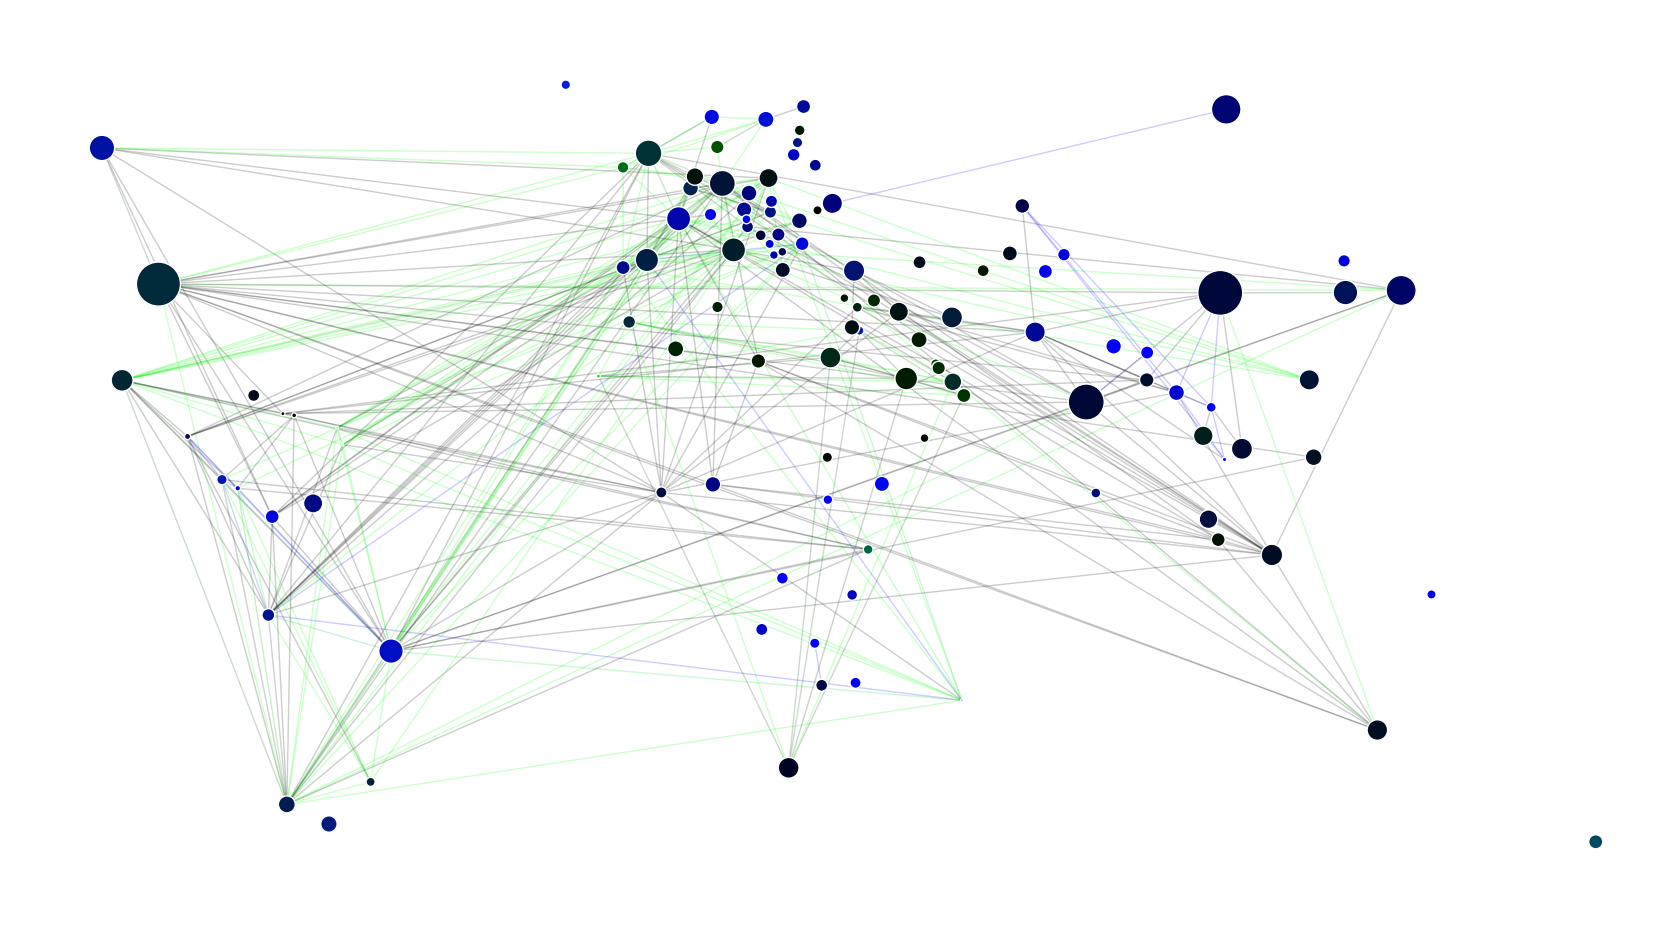

In [11]:
""" make the graph """
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.get_node_attributes(G,'pos')
xs = [pos[k][0] for k,v in pos.iteritems()]
ys = [pos[k][1] for k,v in pos.iteritems()]


n_sizes = nx.get_node_attributes(G,'n_size')
n_colors = nx.get_node_attributes(G,'n_color')
n_alphas = nx.get_node_attributes(G,'n_alpha')
n_type = nx.get_node_attributes(G,'type')

fixed_nodes = [k for k in G.nodes() if n_type[k]=='country']
company_nodes = [k for k in G.nodes() if n_type[k]=='company']

n_cou_sizes = [n_sizes[k] for k in fixed_nodes]
n_cou_colors = [n_colors[k] for k in fixed_nodes]
n_cou_alphas = [n_alphas[k] for k in fixed_nodes]

n_com_sizes = [n_sizes[k] for k in company_nodes]
n_com_colors = [n_colors[k] for k in company_nodes]
n_com_alphas = [n_alphas[k] for k in company_nodes]





e_colors = nx.get_edge_attributes(G,'e_color')

e_colors = [G[u][v]['e_color'] for u,v in G.edges()]
e_colors_d = dict([((u,v),G[u][v]['e_color']) for u,v in G.edges()])
e_type = [((u,v),G[u][v]['type']) for u,v in G.edges()]

e_anchors = [l[0] for l in e_type if l[1]=='country']
e_anchors_colors = [e_colors_d[l] for l in e_anchors]
e_companies = [l[0] for l in e_type if l[1]=='company']
e_companies_colors = [e_colors_d[l] for l in e_companies]
    
fig, ax = plt.subplots(figsize=(16,9 ), dpi=100)

x_min = min(xs)-10
x_max = max(xs)+10
y_min = min(ys)-10
y_max = max(ys)+10

y_lim = [y_min,y_max]
x_lim = [x_min,x_max]
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
    
ax.set_position([0,0,1,1])

#print e_anchors_colors
#print e_anchors
nx.draw_networkx_edges(G, pos, edgelist =e_anchors,  alpha=0.2, ax=ax, edge_color=e_anchors_colors)#, nodelist=[ncenter], alpha=0.4)
#nx.draw_networkx_edges(G, pos, edgelist =e_companies,  alpha=0.2, ax=ax, edge_color=e_companies_colors)#, nodelist=[ncenter], alpha=0.4)
nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=fixed_nodes, node_size = n_cou_sizes, node_color = n_cou_colors,alpha= n_cou_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)
#nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=company_nodes, node_size = n_com_sizes, node_color = n_com_colors,alpha= n_com_alphas)#, nodelist=list(p.keys()),
                           

nodes_ax.set_edgecolor('w')

print 'Generating graphic: '
plt.axis('off')
plt.show()
plt.savefig('output.png')   

In [106]:
def generate_network_graph(nodes, edges, spring_iters=0):

    print '~~~~~~~ GENEARTING GRAPHIC ~~~~~~'

    print 'Getting graph attributes...'

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = nx.get_node_attributes(G,'pos')
    
    pos_prev = pickle.load( open('pos_2017_Q3.pickle','rb'))

    for k,v in pos.items():
        if k in pos_prev.keys():
            pos[k] = pos_prev[k]


    #pos = nx.kamada_kawai_layout(G, k=10, weight='weight', pos=pos, center=[50,50])


    #for n in G:
    #	print n
    #	print n[1]['type'], n_alpha(n), n_color(n), n_size(n)

    #print G.nodes()
    #print pos

    n_sizes = nx.get_node_attributes(G,'n_size')
    n_colors = nx.get_node_attributes(G,'n_color')
    n_alphas = nx.get_node_attributes(G,'n_alpha')
    n_type = nx.get_node_attributes(G,'type')

    fixed_nodes = [k for k in G.nodes() if n_type[k]=='country']
    company_nodes = [k for k in G.nodes() if n_type[k]=='company']

    n_cou_sizes = [n_sizes[k] for k in fixed_nodes]
    n_cou_colors = [n_colors[k] for k in fixed_nodes]
    n_cou_alphas = [n_alphas[k] for k in fixed_nodes]

    n_com_sizes = [n_sizes[k] for k in company_nodes]
    n_com_colors = [n_colors[k] for k in company_nodes]
    n_com_alphas = [n_alphas[k] for k in company_nodes]





    e_colors = nx.get_edge_attributes(G,'e_color')

    e_colors = [G[u][v]['e_color'] for u,v in G.edges()]
    e_colors_d = dict([((u,v),G[u][v]['e_color']) for u,v in G.edges()])
    e_type = [((u,v),G[u][v]['type']) for u,v in G.edges()]

    e_anchors = [l[0] for l in e_type if l[1]=='anchor']
    e_anchors_colors = [e_colors_d[l] for l in e_anchors]
    e_companies = [l[0] for l in e_type if l[1]=='company']
    e_companies_colors = [e_colors_d[l] for l in e_companies]

    #print G.edges()
    #print e_colors
    #print len(e_colors)
    #print len(G.edges())
    #print e_type
    #print fixed_nodes

    #raw_input('-->')
    #print n_sizes
    #print n_colors
    #print n_alphas
    print 'Getting graph attributes: '
    print 'Generating force layout...'

    pos = nx.spring_layout(G, k=50, iterations=spring_iters, pos=pos, fixed=fixed_nodes, center=[0,0])
    pickle.dump(pos,open('pos_2017_Q4.pickle','wb'))

    print 'Generating force layout: '
    print 'Generating graphic...'

    fig, ax = plt.subplots(figsize=(16,9 ), dpi=100)

    xs = [pos[k][0] for k,v in pos.iteritems()]
    ys = [pos[k][1] for k,v in pos.iteritems()]

    x_min = min(xs)-10
    x_max = max(xs)+10
    y_min = min(ys)-10
    y_max = max(ys)+10

    y_lim = [y_min,y_max]
    x_lim = [x_min,x_max]
    ax.set_ylim(y_lim)
    ax.set_xlim(x_lim)
    
    ax.set_position([0,0,1,1])
    #nx.draw_networkx_edges(G, pos, edgelist =e_anchors,  alpha=0.2, ax=ax, edge_color=e_anchors_colors)#, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_edges(G, pos, edgelist =e_companies,  alpha=0.2, ax=ax, edge_color=e_companies_colors)#, nodelist=[ncenter], alpha=0.4)
    #nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=fixed_nodes, node_size = n_cou_sizes, node_color = n_cou_colors,alpha= n_cou_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)
    nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=company_nodes, node_size = n_com_sizes, node_color = n_com_colors,alpha= n_com_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)

    nodes_ax.set_edgecolor('w')

    
    """
    for k,v in n_type.iteritems():
    	if v == 'country':
            try:
    		    #print k,pos[k]
    		    im = Image.open(os.path.join('flags_round','ISO', k+'.png'))
    		    im.thumbnail((16,16), Image.ANTIALIAS)
    		    im = np.array(im).astype(np.float)/255
    		    #print im.shape
    		    #print (pos[k][0] - x_lim[0])/103.*16*100-8, (pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8
    		    fig.figimage(im, xo=(pos[k][0] - x_lim[0])/float(x_lim[1]-x_lim[0])*16*100-8,yo=(pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8, zorder=3)  #offset in pixels.... pix per inch.
    		    #fig.figimage(im, xo= -pos[k][0],yo=pos[k][1])
            except:
                print 'broken country', k
                pass
    """
    
    
    



    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    print 'Generating graphic: '
    plt.axis('off')
    #plt.show()
    plt.savefig('output.png')   


    """
    G = nx.random_geometric_graph(200, 0.125)
    # position is stored as node attribute data for random_geometric_graph
    pos = nx.get_node_attributes(G, 'pos')
    
    # find node near center (0.5,0.5)
    dmin = 1
    ncenter = 0
    for n in pos:
        x, y = pos[n]
        d = (x - 0.5)**2 + (y - 0.5)**2
        if d < dmin:
            ncenter = n
            dmin = d
    
    
    pos = nx.spring_layout(G, iterations=50, pos=pos, center=[0.5,0.5])
    
    # color by path length from node near center
    p = dict(nx.single_source_shortest_path_length(G, ncenter))
    
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                           node_size=80,
                           node_color=list(p.values()),
                           cmap=plt.cm.Reds_r)
    
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    plt.axis('off')
    plt.show() 
    """

In [ ]:
company_subset_df = calculate_CCCE(wepp_df)

In [ ]:
nodes, edges, ADJ_green, ADJ_blue, ADJ_ISO = gen_country_projection(company_subset_df)

In [ ]:
generate_network_graph(nodes, edges)

In [ ]:
print ADJ_green